In [ ]:

from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/Colab Notebooks/Deep lr hw3"
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/Deep lr hw3
Anne.txt  nietzsche.txt


In [ ]:
from torchvision import models,transforms,datasets
import torch
import numpy as np
from torch.utils.data import random_split
import torch.nn as nn
from torch import nn
import numpy as np
from torch import nn, optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm.notebook import  tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(' Running on:', device)

 Running on: cuda


# 1.Preparing the Training data

In [ ]:
import torch
import pandas as pd
from collections import Counter

class prepare_Dataset(torch.utils.data.Dataset):
    def __init__(self,file):
        
        self.file=file
        self.max_length=40
        self.step_size=3
        self.text = self.read_text()
        self.uniq_chars = self.get_uniq_chars()
        
        print('number of unique chars:',len(self.uniq_chars))

        self.index2char = {idx: chr for idx, chr in enumerate(self.uniq_chars)}
        print(self.index2char)
        self.char2index = {chr: idx for idx, chr in enumerate(self.uniq_chars)}
        print(self.char2index)
        self.text2idx = [self.char2index[w] for w in self.text]
        self.sentences=self.get_sentences()

    def read_text(self):
        with open(self.file ,'r') as f:#'Anne.txt' ,encoding='cp1252'
          text = f.read()

        return text#.lower()#making all alphabet to lowercase

    def get_uniq_chars(self):
        #print('**',sorted(set(self.text)))
        return sorted(set(self.text))

    def __len__(self):
        return (len(self.text2idx) - self.max_length-1)//self.step_size
    
    def get_sentences(self):
      sentences=[]
      end=len(self.text)-self.max_length-1
      for i in range(0,end,self.step_size):
        x=torch.tensor(self.text2idx[i : i + self.max_length])
        y=torch.tensor(self.text2idx[i+1 : i+1 + self.max_length])
        sentences.append((x,y))
      return sentences

    def __getitem__(self, idx):
        return self.sentences[idx]

## sample training data

In [ ]:
from torch.utils.data import DataLoader
train_data=prepare_Dataset('nietzsche.txt')
batch_size=64
train_loader=DataLoader(train_data,batch_size=batch_size,drop_last=True)
x,y=next(iter(train_loader))
print(x.shape,y.shape)
x,y

number of unique chars: 84
{0: '\n', 1: ' ', 2: '!', 3: '"', 4: "'", 5: '(', 6: ')', 7: ',', 8: '-', 9: '.', 10: '0', 11: '1', 12: '2', 13: '3', 14: '4', 15: '5', 16: '6', 17: '7', 18: '8', 19: '9', 20: ':', 21: ';', 22: '=', 23: '?', 24: 'A', 25: 'B', 26: 'C', 27: 'D', 28: 'E', 29: 'F', 30: 'G', 31: 'H', 32: 'I', 33: 'J', 34: 'K', 35: 'L', 36: 'M', 37: 'N', 38: 'O', 39: 'P', 40: 'Q', 41: 'R', 42: 'S', 43: 'T', 44: 'U', 45: 'V', 46: 'W', 47: 'X', 48: 'Y', 49: 'Z', 50: '[', 51: ']', 52: '_', 53: 'a', 54: 'b', 55: 'c', 56: 'd', 57: 'e', 58: 'f', 59: 'g', 60: 'h', 61: 'i', 62: 'j', 63: 'k', 64: 'l', 65: 'm', 66: 'n', 67: 'o', 68: 'p', 69: 'q', 70: 'r', 71: 's', 72: 't', 73: 'u', 74: 'v', 75: 'w', 76: 'x', 77: 'y', 78: 'z', 79: 'Æ', 80: 'ä', 81: 'æ', 82: 'é', 83: 'ë'}
{'\n': 0, ' ': 1, '!': 2, '"': 3, "'": 4, '(': 5, ')': 6, ',': 7, '-': 8, '.': 9, '0': 10, '1': 11, '2': 12, '3': 13, '4': 14, '5': 15, '6': 16, '7': 17, '8': 18, '9': 19, ':': 20, ';': 21, '=': 22, '?': 23, 'A': 24, 'B': 25,

(tensor([[39, 41, 28,  ..., 67, 65, 53],
         [29, 24, 26,  ..., 66,  8,  8],
         [28,  0,  0,  ..., 75, 60, 53],
         ...,
         [ 8,  8, 72,  ..., 64, 73, 65],
         [60, 53, 72,  ..., 71, 77,  1],
         [ 1, 72, 60,  ..., 61, 65, 68]]),
 tensor([[41, 28, 29,  ..., 65, 53, 66],
         [24, 26, 28,  ...,  8,  8, 75],
         [ 0,  0,  0,  ..., 60, 53, 72],
         ...,
         [ 8, 72, 60,  ..., 73, 65, 71],
         [53, 72,  1,  ..., 77,  1, 61],
         [72, 60, 57,  ..., 65, 68, 67]]))

##understanding the shapes


*   Number of unique characters in the text = 84
*   Embedding dimension = 300
*   batch_size = 64
*   sequence_length = 40
*   x.shape = [ 64 , 40 ]
*   embedding_dim = 300
*   embed(x).shape = [ 64, 40, 300 ]









In [ ]:
embed=nn.Embedding(84,300)
print(embed(x).shape)

torch.Size([64, 40, 300])


A description of the model parameters

In [ ]:
rnn = nn.GRU(300,128,2)
fc=nn.Linear(128,84)
input = torch.randn(100,40,300)
h0 = torch.randn(2, 40,128)
out, hn = rnn(input, h0)
out=fc(out)
out.shape

torch.Size([100, 40, 84])

# GRU


In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class GRU(nn.Module):
    def __init__(self,n_chars, hidden_size, n_layers):
        super(GRU, self).__init__()
        
        self.hidden_size = 128
        self.n_layers = n_layers
        self.embedding_dim=300
        self.n_chars=n_chars #number of unique characters in txt
        
        self.embedding = nn.Embedding(self.n_chars,self.embedding_dim)
        self.gru = nn.GRU(self.embedding_dim, hidden_size, n_layers,batch_first=True)
        self.fc = nn.Linear(self.hidden_size,self.n_chars)
        #self.dropout = nn.Dropout(0.3)
        self.softmax=nn.Softmax(dim=1)
    
    def forward(self, input, hidden):

        input = self.embedding(input)

        output, hidden = self.gru(input, hidden)
        output = self.fc(output)
        return output, hidden

    def init_state(self,batch_size):
        return Variable(torch.zeros(self.n_layers,batch_size, self.hidden_size))

In [ ]:
def predict(data, model, text,n_chars,seq_len, next_chars,top_n):

    state_h= model.init_state(1)

    for i in range(0, next_chars):
        x = torch.tensor([[data.char2index[char] for char in text[i:]]])

        x,state_h=x.to(device),state_h.to(device)

        out,state_h = model(x,state_h)
       
        out=out.reshape(seq_len,n_chars)
        def sample_from_probs(probs,top_n):
       
          _, idxs = torch.sort(probs)

          # set probabilities after top_n to 0 so that they wont be chosen
          probs[idxs.data[:-top_n]] = 0
          sampled_idx = torch.multinomial(probs, 1)
          return sampled_idx

        probs = torch.nn.functional.softmax(out[-1].cpu(), dim=0)
        #print(o)
        y_pred = sample_from_probs(probs,top_n)
        text=text+str(data.index2char[y_pred.item()])

    print(text)
begining_sentence='Is there not ground for suspecting that '
print(len(begining_sentence))
#20 epoch

40


In [ ]:
n_epochs = 36
hidden_size = 128
n_layers = 2
n_chars=84
seq_len=40
batch_size=64
model=GRU(n_chars, hidden_size, n_layers).to(device)
print('******** prediction before training **********')
predict(train_data,model,begining_sentence,84,40,400,5)

******** prediction before training **********
Is there not ground for suspecting that iRÆ22=2athhääë?G_a]f]FäEGfwæf]EGæäæEævææväEvbäwv 5252?2f???_a'ffæihææææl"92=æTëäfbæv_ä8((()Ff_]fCwHHwEGGfwww_Uvbææäv2ëE_äUvvCC2aV2M?a Cy_aalyG'GG-æäfwHæfæEGwwHGGGéæwä02jé)

GëZGäGLffGfæfwææä8ffEU b]wBbl2bGäv2baaää(_?_?'f]]fæf w2H==ëaa(''V;EÆ
hhGæfæTfäwæEv bväbH]Bl2bBll2,_a_aCf(haaCVäy2æEää??Gë?]za_ySvw]äb2v?aCy'äEE_?v? ?(CfhææfväwwEää?b?z_Saal;_Æ(Sf_w]w2fE Uvb ww52E?? '('hÆfGEæUEäGGGw00æffEw HG]ww


## training the GRU model

In [ ]:
n_epochs = 36
hidden_size = 128
n_layers = 2
n_chars=84
seq_len=40
batch_size=64
model=GRU(n_chars, hidden_size, n_layers).to(device)

model.train()
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=5e-4)
optimizer=torch.optim.RMSprop(model.parameters(), lr=0.001)
losses=[]

for epoch in tqdm(range(n_epochs)):
        hidden= model.init_state(batch_size)
        optimizer.zero_grad()
        
        bloss,loss=0,0

        for batch, (x, y) in enumerate(train_loader):
            optimizer.zero_grad()
            x,y,hidden=x.to(device),y.to(device),hidden.to(device)
            
            out,hidden = model(x,hidden)
            #y.shape=[64, 40]=[batch_size,sequence_length]
            #out.shape=[64, 40, 84]=[batch_size,sequence_length,n_unique_chars]
            #hidden.shape=[2, 64, 128]=[num_layers,batch_size,hidden_size]
            
            y_pred=torch.argmax(out,dim=1).to(device)
          
            loss = criterion(out.permute(0, 2, 1).to(device),y)
            
            bloss+=loss.item()
            hidden = hidden.detach()
            loss.backward()
            #nn.utils.clip_grad_norm_(model.parameters(),4)
            optimizer.step()
        if epoch%5==0:
            print()
            print('************ epoch '+str(epoch)+' generated text **************')
            predict(train_data,model,begining_sentence,n_chars,seq_len,400,5)
            print()

        losses.append(bloss/len(train_loader))
        print('on epoch: '+str(epoch)+' loss per batch = '+str(bloss/len(train_loader)))

#lr 5e-4 bad nis ba embed dim=128 2.01 > 1.68 > 1.59 > 1.51 ....> 1.34 > 1.32


************ epoch 0 generated text **************
Is there not ground for suspecting that the
extraint of the present but the clander, the
existed took still their wish and the consciaine as sucting of sancticy of the
saintly.--A her timended in his sonal to because
to the sense
as a saysed,
but sinflice
and the sensions, thinked as the prophers, a chisted in
always
them an as
whation that that saints and himself
a perturained that was said by the endom that there is they are are inten

on epoch: 0 loss per batch = 1.814729592829857
on epoch: 1 loss per batch = 1.5984985776967078
on epoch: 2 loss per batch = 1.5366369066393843
on epoch: 3 loss per batch = 1.5023022430245585
on epoch: 4 loss per batch = 1.4790220856857057

************ epoch 5 generated text **************
Is there not ground for suspecting that that the saints of all sains, that which worked and a glation and
eved they are not that source with the sames when inspecial sations, because of the saints the station of the

## Evaluating the GRU model


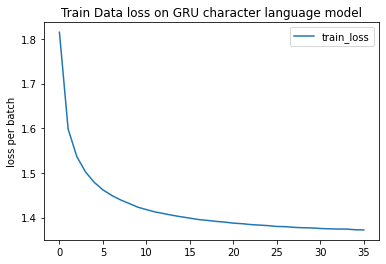

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses, label='train_loss')
plt.title('Train Data loss on GRU character language model')
plt.ylabel('loss per batch')
plt.legend()
plt.show()

In [ ]:
predict(train_data,model,begining_sentence,84,40,400,5)

Is there not ground for suspecting that the spare, who have steen the saint, we heart than the same idea of an
every soul, so that the
community of his significance would not become supposes to
condivilian to the specision and such as in theirs somethic in the souls.
The self expendent they clungled since the contatural standard, and in the saint and have been a personal sensess of sin that templation, the saints and sinful exerding,
no


In [ ]:
losses

[1.814729592829857,
 1.5984985776967078,
 1.5366369066393843,
 1.5023022430245585,
 1.4790220856857057,
 1.4621695318935244,
 1.4498518091605928,
 1.4399579234990345,
 1.4317923556809686,
 1.423533722515417,
 1.4179682435986332,
 1.4127706134993643,
 1.4090238649573101,
 1.4052433134382547,
 1.4018721068084488,
 1.3988981002357754,
 1.3957405616849252,
 1.3938573265121401,
 1.3916506184751365,
 1.3900476716584997,
 1.3877064918473567,
 1.3864663186717925,
 1.3845115040544125,
 1.3833126945593137,
 1.3821448314757574,
 1.3802590926031062,
 1.3798383904478733,
 1.3782643255771407,
 1.377378038645324,
 1.3770465794063749,
 1.3757270909833923,
 1.375016732351511,
 1.3745592344146293,
 1.3743674391639542,
 1.3729718606972625,
 1.3725431508704016]

حواست باشه اگه جمله ی اولی که میدی دقیقا اندازش 40 نباشه چرت و پرت میسازه

# LSTM

In [ ]:
class LSTM(nn.Module):
    def __init__(self,n_chars,embedding_dim,hidden_size,n_layers):
        super(LSTM, self).__init__()
        
        self.n_chars = n_chars
        self.hidden_size = hidden_size
        self.embedding_dim = embedding_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(
            num_embeddings = n_chars,
            embedding_dim = embedding_dim)
        
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            num_layers=self.n_layers,batch_first=True)
        self.fc = nn.Linear(hidden_size, n_chars)

    def forward(self, x,states):
        embedding = self.embedding(x)
        out,(h,c) = self.lstm(embedding,states)
        out = self.fc(out)
        return out,(h,c)

    def init_state(self,batch_size):
        return (torch.zeros(self.n_layers,batch_size, self.hidden_size),
                torch.zeros(self.n_layers,batch_size, self.hidden_size))

## Training LSTM model

In [ ]:
n_epochs = 36
hidden_size = 128
n_layers = 2
n_chars=84
batch_size=64
embedding_dim=300
model=LSTM(n_chars,embedding_dim,hidden_size,n_layers).to(device)

model.train()
criterion = nn.CrossEntropyLoss()
optimizer=torch.optim.RMSprop(model.parameters(), lr=0.001)

losses_l=[]
for epoch in tqdm(range(n_epochs)):
        h,c = model.init_state(batch_size)
        bch_loss=0
        for i, (x, y) in enumerate(train_loader):
            
            optimizer.zero_grad()
            x,y=x.to(device),y.to(device)
            h,c=h.to(device),c.to(device)

            out, (h,c) = model(x, (h,c))
            #print(out.shape,y.shape)
            
            #out.shape=[64, 40, 70]= [batch_size,seq_length,n_unique_chars]
            #y.shape=[64, 40]=[batch_size,seq_length]
            loss = criterion(out.permute(0,2,1), y)
            bch_loss+=loss.item()
            h = h.detach()
            c = c.detach()

            loss.backward()
            optimizer.step()
        losses_l.append(bch_loss)
        print('on epoch '+str(epoch)+' loss per batch = '+str(bch_loss/len(train_loader)))

on epoch 0 loss per batch = 1.8784583496110208
on epoch 1 loss per batch = 1.6265023059454846
on epoch 2 loss per batch = 1.548982264973478
on epoch 3 loss per batch = 1.5045205325735915
on epoch 4 loss per batch = 1.4741965936905814
on epoch 5 loss per batch = 1.4513803099854452
on epoch 6 loss per batch = 1.4333052429462554
on epoch 7 loss per batch = 1.4184000294366252
on epoch 8 loss per batch = 1.406059772185755
on epoch 9 loss per batch = 1.3953554004326
on epoch 10 loss per batch = 1.3862854287280713
on epoch 11 loss per batch = 1.3781698111262555
on epoch 12 loss per batch = 1.3709706308438627
on epoch 13 loss per batch = 1.3644888572092444
on epoch 14 loss per batch = 1.3588259716542928
on epoch 15 loss per batch = 1.3541278031810322
on epoch 16 loss per batch = 1.3494039050075108
on epoch 17 loss per batch = 1.3448741732408689
on epoch 18 loss per batch = 1.3406615156683916
on epoch 19 loss per batch = 1.3368831238985899
on epoch 20 loss per batch = 1.3330336443415538
on epoc

## Evaluating lstm model

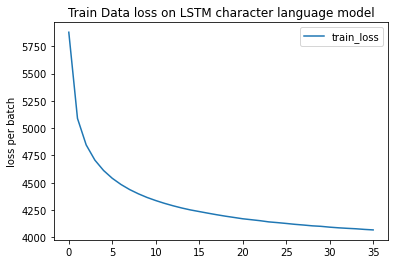

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses_l, label='train_loss')
plt.title('Train Data loss on LSTM character language model')
plt.ylabel('loss per batch')
plt.legend()
plt.show()

## Prediction via LSTM model

In [ ]:
def predict_lstm(dataset, model, text,n_chars,seq_length ,next_chars,top_n):
    model.eval()
    h,c = model.init_state(1)

    for i in range(0,next_chars):
        
        x = torch.tensor([[dataset.char2index[w] for w in text[i:]]]).to(device)
        h,c=h.to(device),c.to(device)
        out, (h, c) = model(x, (h,c))
        out=out.to(device)
        out=out.reshape(seq_length ,n_chars)
        
        def sample_from_probs(probs,top_n):
       
          _, idxs = torch.sort(probs)
          # set probabilities after top_n to 0 so that they won't not chosen
          probs[idxs.data[:-top_n]] = 0
          sampled_idx = torch.multinomial(probs, 1)
          return sampled_idx

        softmax = nn.Softmax(dim=0)
        probs = softmax(out[-1].cpu())#out[-1] is the probabilites for last character of the text(n_char probs) 
        y_pred = sample_from_probs(probs,top_n)
        text=text+str(dataset.index2char[y_pred.item()])

    print(text)
begining_sentence='Is there not ground for suspecting that '
print(len(begining_sentence))
predict_lstm(train_data,model,begining_sentence,84,40,400,5)

40
Is there not ground for suspecting that the imagination with
the saint influence that
the most disguisitation and sole that
the
enemy of this god, the saint torture was their own self manner, without her own state, when actor a distrustful of the imaginations, the species. The potent stin it as always in the saints which ascets of the important to any perfensity. Its feelings, who, the angian
impossible for the ancient of the strength,



# Camparing LSTM and GRU char language model

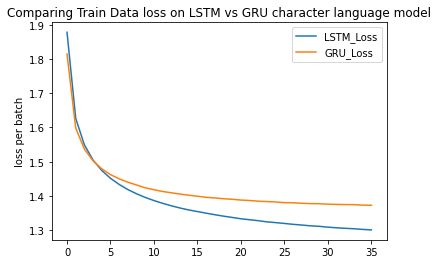

In [ ]:
loss_lstm=[x/len(train_loader) for x in losses_l]
import matplotlib.pyplot as plt
plt.plot(loss_lstm, label='LSTM_Loss')
plt.plot(losses, label='GRU_Loss')
plt.title('Comparing Train Data loss on LSTM vs GRU character language model')
plt.ylabel('loss per batch')
plt.legend()
plt.show()